In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pwd

'/kaggle/working'

In [4]:
from zipfile import ZipFile
from pathlib import Path

# set the path for train and test
output_path = Path('/kaggle/working/data')
output_path.mkdir(exist_ok=True)

# extract the train file 
train_zip = ZipFile('/kaggle/input/nyc-taxi-trip-duration/train.zip')
train_zip.extractall(output_path/'train')

# extract the test file
test_zip = ZipFile('/kaggle/input/nyc-taxi-trip-duration/test.zip')
test_zip.extractall(output_path/'test')

In [5]:
# checking if data path exist or not 

training_data_path = Path('/kaggle/working/data/train/train.csv')

if training_data_path.exists():
    print('The data path exists')
else:
    print('The data path does not exist')

The data path exists


In [6]:
train_df = pd.read_csv(training_data_path)
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
train_df.shape

(1458644, 11)

In [8]:
train_df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

In [9]:
train_df['id'].value_counts()

id
id2875421    1
id2249290    1
id2484008    1
id3901436    1
id1265174    1
            ..
id2478352    1
id1159014    1
id3007971    1
id3965191    1
id1209952    1
Name: count, Length: 1458644, dtype: int64

- `store_and_fwd_flag` column is highly imbalanced
- every trip is with unique`id`
- So, we remove these two columns

In [10]:
# Drop unwanted columns
train_df.drop(columns=['id', 'store_and_fwd_flag'], inplace=True)

In [11]:
train_df.shape

(1458644, 9)

In [12]:
train_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


<Axes: xlabel='trip_duration', ylabel='Density'>

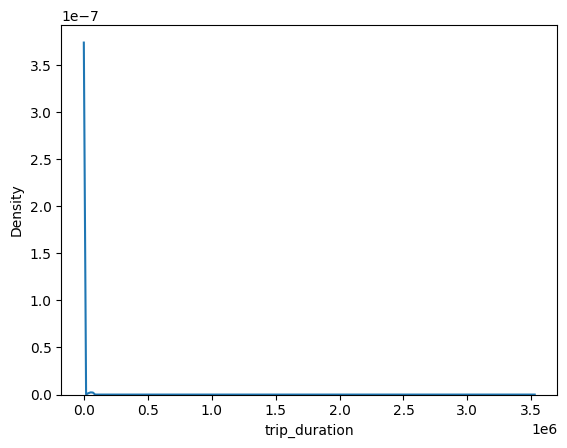

In [13]:
import seaborn as sns
sns.kdeplot(train_df['trip_duration'])

<Axes: xlabel='trip_duration', ylabel='Density'>

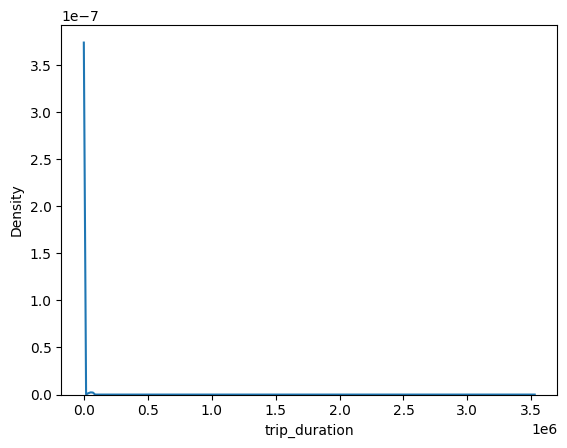

In [14]:
sns.kdeplot(train_df['trip_duration'], bw_adjust=1)

In [15]:
train_df['trip_duration'].skew()

343.1639435917362

### apply powertransformer

In [16]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')


In [17]:
ftr = transformer.fit_transform(train_df[['trip_duration']])

<Axes: ylabel='Density'>

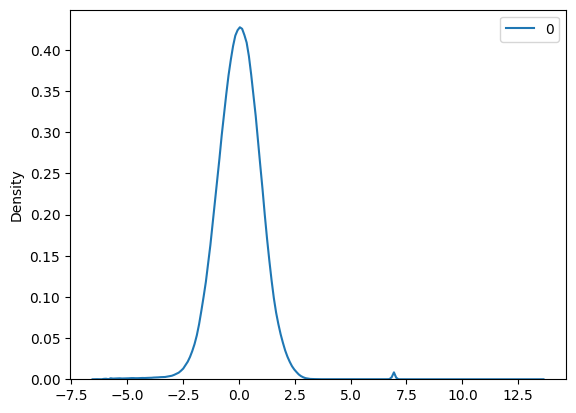

In [18]:
sns.kdeplot(ftr)

In [19]:
ftr_series = ftr.squeeze()

In [20]:
pd.Series(ftr_series).skew()

0.05206556901945714

## apply log transformation

In [21]:
target_log_trans = train_df['trip_duration'].apply(np.log)

<Axes: xlabel='trip_duration', ylabel='Density'>

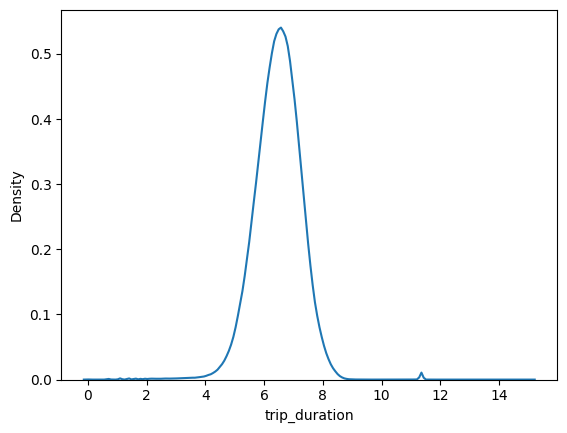

In [22]:
sns.kdeplot(target_log_trans)

In [23]:
target_log_trans.skew()

-0.34070423044801745

**-  the distribution of power transformation is less skewed as compare to log transformation**

In [24]:
print('min value of trip in seconds: ', train_df['trip_duration'].min())
print('max value of trip in days: ', train_df['trip_duration'].max()/(60))
print('average value of trip in hrs: ', train_df['trip_duration'].mean()/(60))

min value of trip in seconds:  1
max value of trip in days:  58771.36666666667
average value of trip in hrs:  15.991537882672764


<Axes: xlabel='trip_duration'>

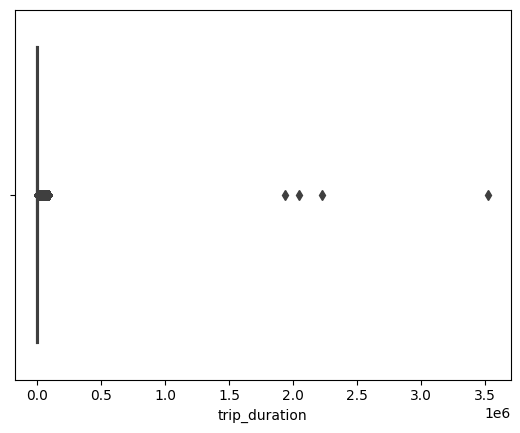

In [25]:
sns.boxplot(data=train_df, x='trip_duration')

<Axes: >

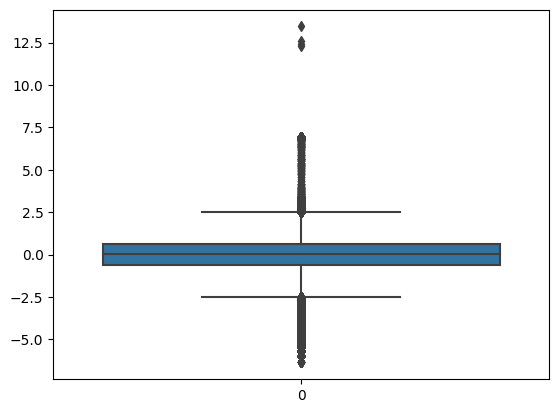

In [26]:
# box plot on powertransformed data

sns.boxplot(ftr)

In [27]:
ftr.max()

13.45427437691909

In [28]:
# target below 200 minutes

dur_thres = 200*60

target_below_200 = train_df[train_df['trip_duration']<dur_thres]

In [29]:
train_df.shape[0] - target_below_200.shape[0]

2096

In [30]:
print('Number of rows drop when trip duration above 200 minutes: ', train_df.shape[0]-target_below_200.shape[0])
print('Percentage of rows drop when trip duration above 200 minutes: ', f'{(train_df.shape[0]-target_below_200.shape[0])/train_df.shape[0]:.2%}')

Number of rows drop when trip duration above 200 minutes:  2096
Percentage of rows drop when trip duration above 200 minutes:  0.14%


**Not a lot of data removes as compare to total size of data**

<Axes: ylabel='trip_duration'>

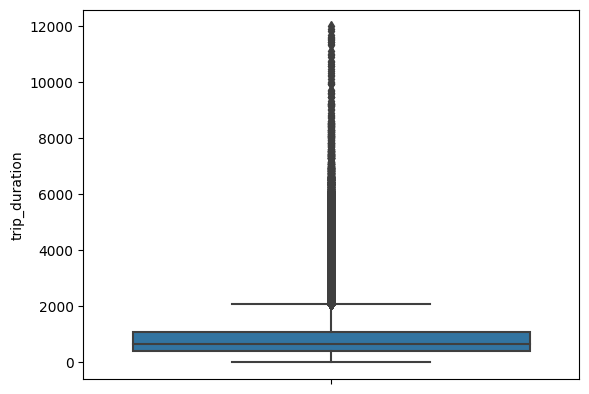

In [31]:
sns.boxplot(data=target_below_200, y='trip_duration')

<Axes: xlabel='trip_duration', ylabel='Density'>

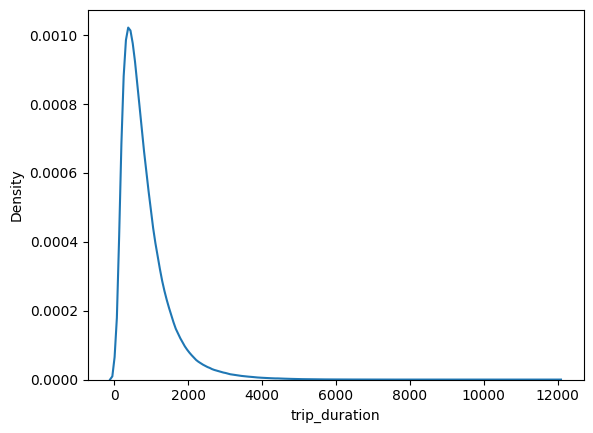

In [32]:
sns.kdeplot(target_below_200['trip_duration'])

power transformation

In [33]:
targets_below_200 = target_below_200['trip_duration']
targets_below_200

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1456548, dtype: int64

In [34]:
pt = PowerTransformer(method='yeo-johnson')
target_power_trans = pt.fit_transform(targets_below_200.to_frame())
target_power_trans

array([[-0.50188624],
       [-0.01972708],
       [ 1.69949474],
       ...,
       [ 0.17065257],
       [-0.74328395],
       [-1.45623401]])

<Axes: ylabel='Density'>

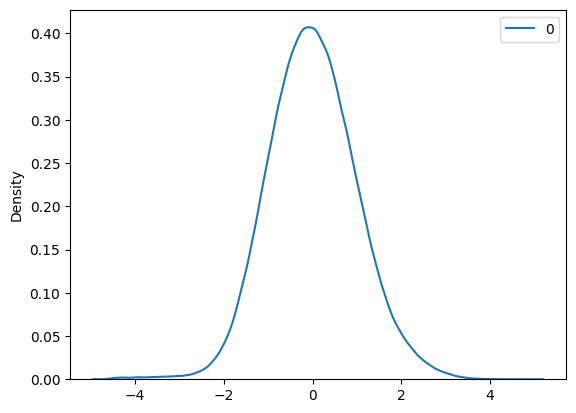

In [35]:
sns.kdeplot(target_power_trans)

In [36]:
pd.Series(target_power_trans.flatten()).skew()

0.032368541395952605

<Axes: >

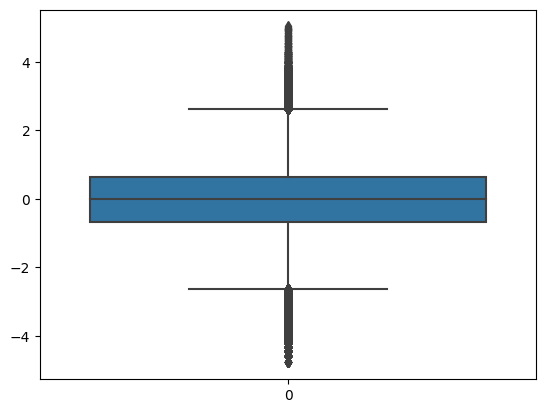

In [37]:
sns.boxplot(target_power_trans)

log transformation

In [38]:
target_below_200_log = targets_below_200.apply(np.log)

<Axes: xlabel='trip_duration', ylabel='Density'>

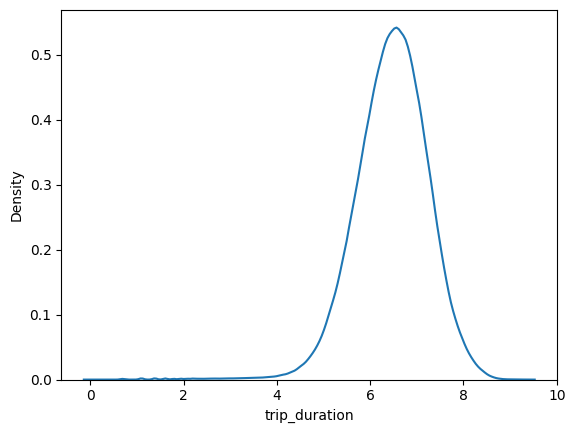

In [39]:
sns.kdeplot(target_below_200_log)

In [40]:
target_below_200_log.skew()

-0.6887975071074691

- it is quite evident from the observations that for the given dataset for powertransform work better as compared to the others

In [41]:
pt.lambdas_[0]

0.1816048673119821

In [42]:
# applying both 'yeo-johnson' and 'box-cox' transformation

transformation_methods = ['yeo-johnson', 'box-cox']
skewness = [targets_below_200.skew()]
methods = ['original']
lambdas = [np.NaN]

for method in transformation_methods:
    methods.append(method)
    pt = PowerTransformer(method=method)
    target_trans = pt.fit_transform(targets_below_200.to_frame())
    target_trans_flat = target_trans.flatten()
    skew = pd.Series(target_trans_flat).skew()
    skewness.append(skew)
    lambdas.append(f'{pt.lambdas_[0]:.3f}')

results_df = pd.DataFrame(data={
    'methods': methods,
    'skewness': skewness,
    'lambdas': lambdas
})

results_df

,methods,skewness,lambdas
0,original,2.337973,NaN
1,yeo-johnson,0.032369,0.182
2,box-cox,0.035812,0.187


### Outliers Removal from Lat/Long columns

In [43]:
target_below_200.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


In [44]:
import matplotlib.pyplot as plt
def plot_density_plots(df):
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
    # density plot for pickup latitude
    sns.kdeplot(data=df,x='pickup_latitude',ax=ax1[0])
    # density plot for dropoff latitude
    sns.kdeplot(data=df,x='dropoff_latitude',ax=ax1[1])
    # density plot for pickup longitude
    sns.kdeplot(data=df,x='pickup_longitude',ax=ax2[0])
    # density plot for pickup longitude
    sns.kdeplot(data=df,x='dropoff_longitude',ax=ax2[1])
    
def plot_boxplots(df):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    sns.boxplot(data=df, y='dropoff_longitude', ax = ax1[0])
    sns.boxplot(data=df, y='dropoff_latitude', ax=ax1[1])
    sns.boxplot(data=df, y='pickup_longitude', ax=ax2[0])
    sns.boxplot(data=df, y='pickup_latitude', ax=ax2[1])

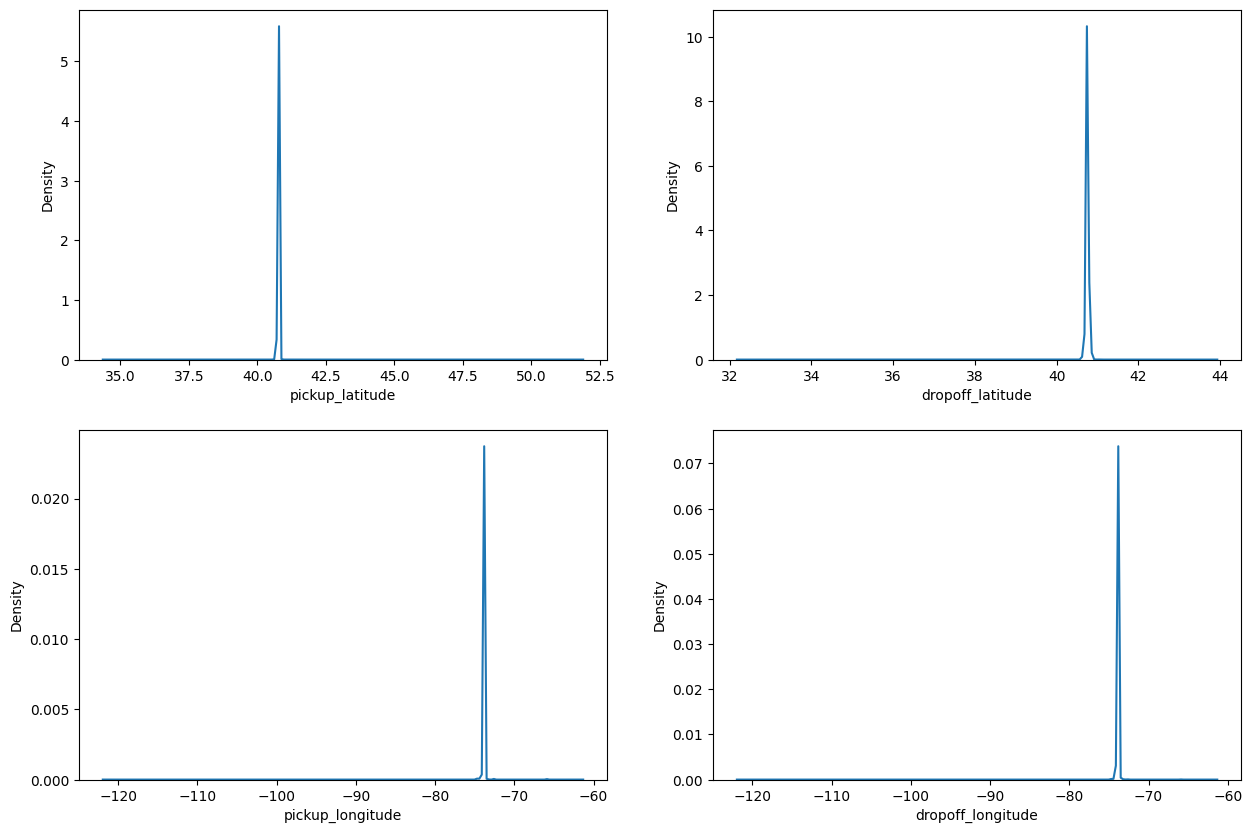

In [45]:
plot_density_plots(target_below_200)

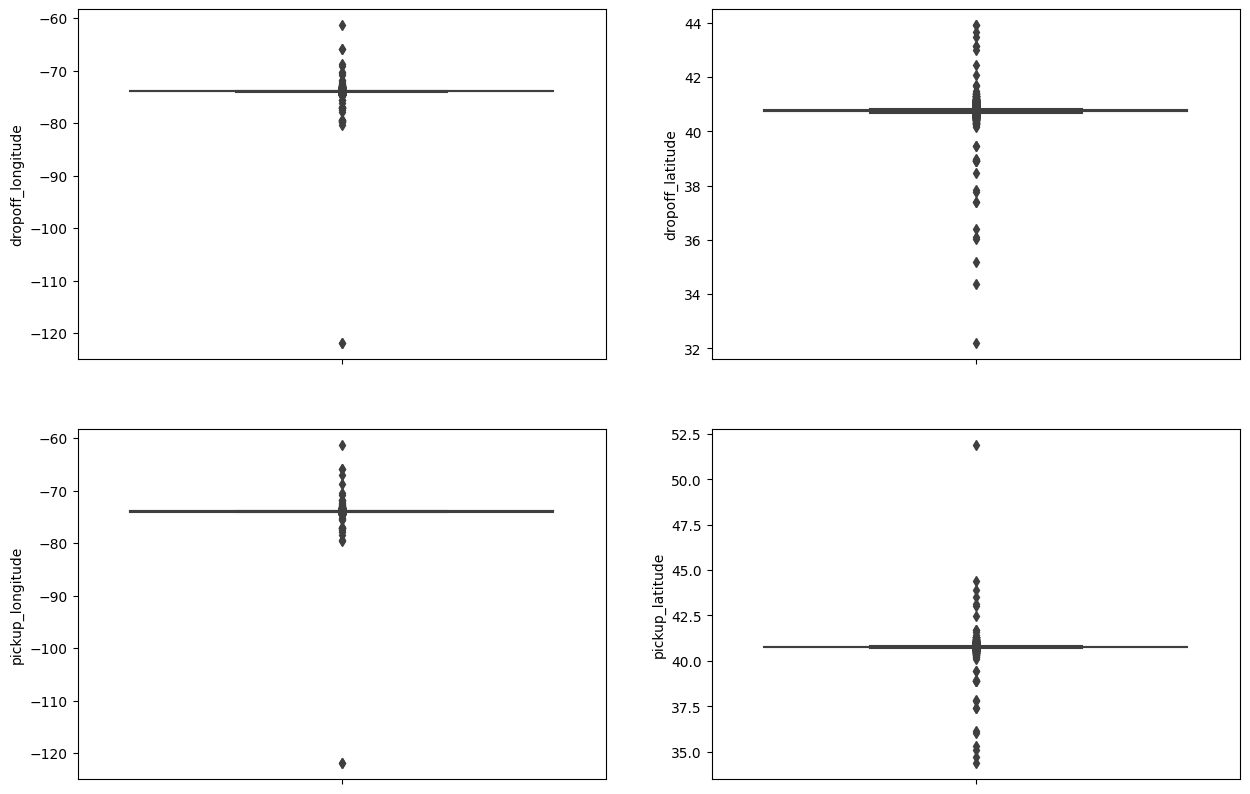

In [46]:
plot_boxplots(target_below_200)

In [47]:
# function to remove outliers from data

def remove_outliers(percentiles, column_names):
    original_number_of_rows = target_below_200.shape[0]
    rows_removed = {}
    df_after_removal = target_below_200.copy()
    for column in column_names:
        quantile_values = target_below_200[column].quantile(list(percentiles))
        data_filter = (target_below_200[column]>=quantile_values.iloc[0]) & (target_below_200[column]<=quantile_values.iloc[1])
        df_after_removal = df_after_removal.loc[data_filter]
        rows_removed[column] = original_number_of_rows - df_after_removal.shape[0]
        original_number_of_rows = df_after_removal.shape[0]
    print(rows_removed)
    return df_after_removal, rows_removed

In [48]:
percentile_values = (0.002, 0.998)
outliers_columns = target_below_200.columns[4:8]

In [49]:
df_without_outliers, removal_dict = remove_outliers(percentile_values, outliers_columns)

{'pickup_longitude': 5698, 'pickup_latitude': 5479, 'dropoff_longitude': 5032, 'dropoff_latitude': 4700}


In [50]:
removal_dict

{'pickup_longitude': 5698,
 'pickup_latitude': 5479,
 'dropoff_longitude': 5032,
 'dropoff_latitude': 4700}

In [51]:
sum(removal_dict.values())

20909

In [52]:
# percentage of data points removed after outliers removal
per_of_removed_data = (target_below_200.shape[0]-df_without_outliers.shape[0])/(target_below_200.shape[0])

print(f'Percentage of data points removed after outlier removal from lat/long columns: {per_of_removed_data:.2%}')

Percentage of data points removed after outlier removal from lat/long columns: 1.44%


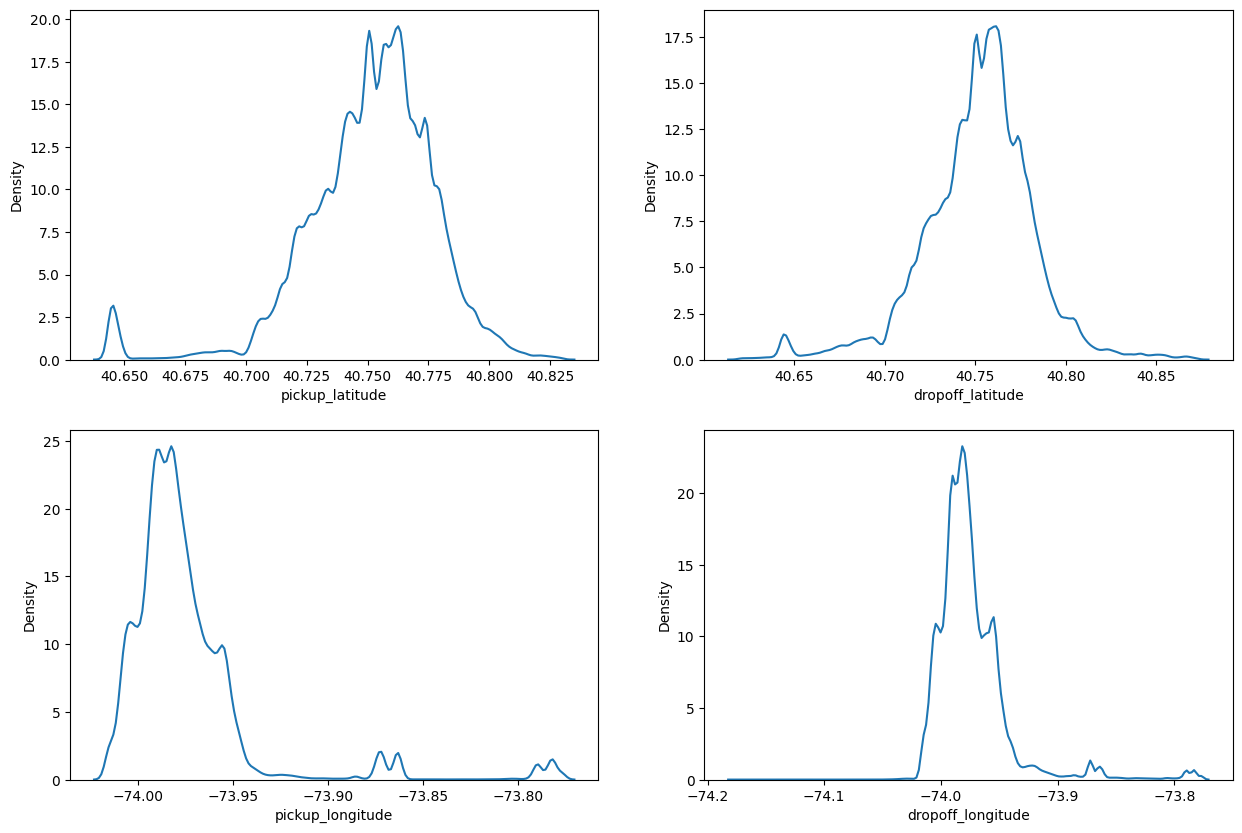

In [53]:
plot_density_plots(df_without_outliers)

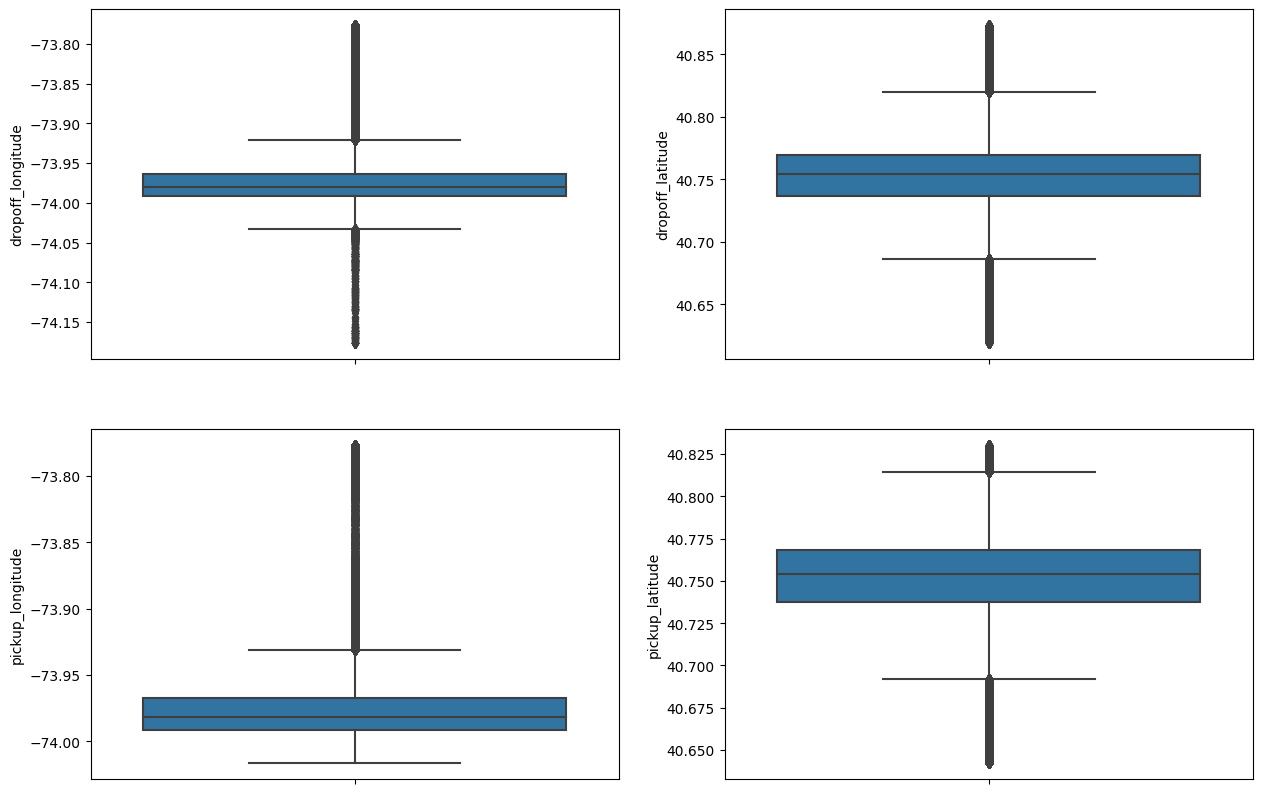

In [54]:
plot_boxplots(df_without_outliers)

In [55]:
# skewness of lat/long columns

df_without_outliers[outliers_columns].skew().to_frame(name='skewness').iloc[[1, 3, 0, 2]]

,skewness
pickup_latitude,-1.101700
dropoff_latitude,-0.485723
pickup_longitude,3.341363
dropoff_longitude,2.867819


In [56]:
def apply_transformation(func):
    for i in range(len(func)):
        original_skew = df_without_outliers[f'{list(outliers_columns)[i]}'].skew()
        print(f'The skewness of column {list(outliers_columns)[i]} before transformation is {original_skew}')
        skewness_atr_transformation = df_without_outliers[f'{list(outliers_columns)[i]}'].apply(func[i]).skew()
        print(f'The skewness of column {list(outliers_columns)[i]} after transformation is {skewness_atr_transformation}')
        print('\n', '*'*30, '\n')

- **Log transformations are often used to reduce positive skewness by compressing large values.**
- **Cubing can be used for transformation in the opposite direction, often inflating smaller values to reduce skewness when values are negatively skewed.**

In [57]:
log_func = lambda x : -np.log(abs(x))
cube_func= lambda x : x**3

In [58]:
function_list = [log_func, cube_func, log_func, cube_func]
apply_transformation(func=function_list)

The skewness of column pickup_longitude before transformation is 3.34136276335352
The skewness of column pickup_longitude after transformation is 3.3446186975280146

 ****************************** 

The skewness of column pickup_latitude before transformation is -1.101700482506364
The skewness of column pickup_latitude after transformation is -1.0940057075543879

 ****************************** 

The skewness of column dropoff_longitude before transformation is 2.867818797501469
The skewness of column dropoff_longitude after transformation is 2.8718140021587675

 ****************************** 

The skewness of column dropoff_latitude before transformation is -0.48572306780467744
The skewness of column dropoff_latitude after transformation is -0.4769448478791475

 ****************************** 



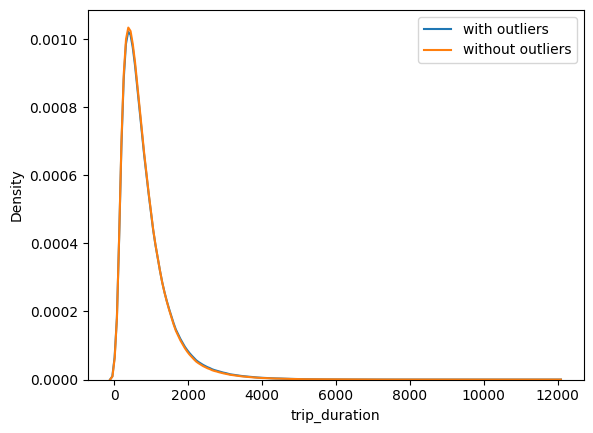

In [59]:
sns.kdeplot(data=target_below_200, x='trip_duration', label='with outliers')
sns.kdeplot(data=df_without_outliers, x='trip_duration', label='without outliers')
plt.legend()
plt.show()

### Passenger count

In [60]:
df_without_outliers.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


In [61]:
df_without_outliers.shape

(1435639, 9)

In [62]:
df_without_outliers['passenger_count'].value_counts()

passenger_count
1    1017699
2     206726
5      76789
3      58932
6      47552
4      27888
0         52
8          1
Name: count, dtype: int64

- 0 and 8 look like outliers

In [63]:
final_df = df_without_outliers[~df_without_outliers['passenger_count'].isin([0,8])]

In [64]:
final_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


In [65]:
# compare the shape
print('The shape of data before removing passenger_count 0 and 8 is ', df_without_outliers.shape[0])
print('The sahpe of data after removing passenger_count 0 and 8 is  ', final_df.shape[0])
print('Total difference of rows befor and after removal of passenger_count 0 and 8 is', df_without_outliers.shape[0]-final_df.shape[0])

The shape of data before removing passenger_count 0 and 8 is  1435639
The sahpe of data after removing passenger_count 0 and 8 is   1435586
Total difference of rows befor and after removal of passenger_count 0 and 8 is 53


In [66]:
# save the final_df
save_path = Path('/kaggle/working/data/output')
save_path.mkdir(exist_ok=True)

In [67]:
final_df.to_csv(save_path/'final_df.csv', index=False)

In [68]:
final_df_copy = pd.read_csv(save_path/'final_df.csv')
final_df_copy.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435
